# Goal - Make EfficientNet

In [1]:
import os
import math
import keras
import random
import string
import collections
import numpy as np
import pandas as pd
from random import shuffle
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import backend
from keras.models import load_model
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, GlobalAveragePooling2D, Dropout
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras import layers
from keras.utils.generic_utils import get_custom_objects
class Swish(layers.Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (backend.sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})

## Step 1: Dataset Setup, etc.

In [3]:
random.seed(42)
train_dir, test_dir = './cancer_dataset/train/train/', './cancer_dataset/test/test'

In [4]:
train_data = pd.read_csv('./cancer_dataset/train.csv')
train_data['train_file'] = train_data.Id.apply(lambda x: './cancer_dataset/train/train/{0}'.format(x))

In [5]:
train_data.head(1)

,Id,Category,train_file
0,0000.png,08_EMPTY,./cancer_dataset/train/train/0000.png


In [6]:
msk = np.random.rand(len(train_data)) < 0.8
train_df = train_data[msk]
val_df = train_data[~msk]

In [7]:
print(len(train_df.index), len(val_df.index))

3583 917


In [8]:
print("Num Samples: ", len(train_data.index))
print("Image Shape: ", imread(train_df.iloc[0].train_file).shape)

Num Samples:  4500
Image Shape:  (150, 150, 3)


In [9]:
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=90,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             fill_mode='reflect',
                             zoom_range=[0.8, 1.1],
                             horizontal_flip=True,
                             vertical_flip=True,
                             brightness_range=[0.8, 1.1],
                             channel_shift_range=12)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [10]:
train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=train_dir,
                                             x_col='Id',
                                             y_col='Category',
                                             target_size=(150, 150),
                                             class_mode='categorical',
                                             batch_size=32,
                                             seed=7)

validation_generator = val_datagen.flow_from_dataframe(dataframe=val_df, directory=train_dir,
                                             x_col='Id',
                                             y_col='Category',
                                            shuffle=False,
                                             target_size=(150, 150),
                                             class_mode='categorical',
                                             batch_size=100,
                                             seed=7)

Found 3583 validated image filenames belonging to 8 classes.
Found 917 validated image filenames belonging to 8 classes.


## Step 2: Create MB Conv

In [11]:
from keras import layers, models

In [31]:
# The original MobileNetV2 network uses RELU6 as its activation function, but efficientnet uses swish.  As a result we will add the activation function as a param
def new_mb_conv_block(input_layer, input_filters, output_filters, block_prefix, bn_axis=3, activation_fn="swish", depthwise_kernel_size=3, depthwise_strides=[1,1], expand_ratio=1, se_ratio=1, drop_rate=None):
    # Expansion Phase
    x = input_layer
    if expand_ratio != 1:
        x = layers.Conv2D(int(input_filters*expand_ratio), 1, padding='same', use_bias=False, name=f"{block_prefix}expand_conv")(x)
        x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}expand_bn")(x)
        x = layers.Activation(activation_fn, name=f"{block_prefix}expand_activation")(x)
    # Depthwise Convolution
    x = layers.DepthwiseConv2D(depthwise_kernel_size, strides=depthwise_strides, padding='same', use_bias=False, name=f"{block_prefix}dwconv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}bn")(x)
    x = layers.Activation(activation_fn, name=f"{block_prefix}activation")(x)
    # Squeeze and Excitation
    squeeze_filter_size = max(1, int(input_filters*se_ratio))
    target_shape = (1, 1, int(input_filters*expand_ratio)) if bn_axis==3 else (int(input_filters*expand_ratio), 1, 1)
    se = layers.GlobalAveragePooling2D(name=f"{block_prefix}se_squeeze")(x)
    se = layers.Reshape(target_shape, name=f"{block_prefix}se_reshape")(se)
    se = layers.Conv2D(squeeze_filter_size, 1, padding='same', activation=activation_fn, use_bias=True, name=f"{block_prefix}se_reduce")(se)
    se = layers.Conv2D(int(input_filters*expand_ratio), 1, padding='same', activation='sigmoid', use_bias=True, name=f"{block_prefix}se_expand")(se) # We are getting weights for the features between 0 and 1, making sigmoid a good choice here
    x = layers.multiply([x, se], name=f"{block_prefix}se_excite")
    # Projection Phase
    x = layers.Conv2D(output_filters, 1, padding='same', use_bias=False, name=f"{block_prefix}project_conv")(x)
    x = layers.BatchNormalization(axis=bn_axis, name=f"{block_prefix}project_bn")(x)
    print(input_filters, output_filters, depthwise_strides)
    if input_filters == output_filters and all([x == 1 for x in depthwise_strides]):
        if drop_rate and drop_rate > 0:
            print("here", drop_rate)
            x = layers.Dropout(drop_rate, name=f"{block_prefix}drop")(x)
        x = layers.add([x, input_layer], name=f"{block_prefix}add")
    return x

In [13]:
# mb_input = layers.Input((112, 112, 32))
# mb_out = new_mb_conv_block(mb_input, 32, 16, "block_prefix", se_ratio=0.25)
# models.Model(mb_input, mb_out).summary()

## Step 3: Create EfficientNet

In [14]:
BlockArgs = collections.namedtuple('BlockArgs', [
    'depthwise_kernel_size', 'num_repeat', 'input_filters', 'output_filters',
    'expand_ratio', 'id_skip', 'strides', 'se_ratio'
])
BASELINE_NETWORK_PARAMS = [
    BlockArgs(depthwise_kernel_size=3, num_repeat=1, input_filters=32, output_filters=16,
              expand_ratio=1, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=3, num_repeat=2, input_filters=16, output_filters=24,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=5, num_repeat=2, input_filters=24, output_filters=40,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=3, num_repeat=3, input_filters=40, output_filters=80,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=5, num_repeat=3, input_filters=80, output_filters=112,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=5, num_repeat=4, input_filters=112, output_filters=192,
              expand_ratio=6, id_skip=True, strides=[2, 2], se_ratio=0.25),
    BlockArgs(depthwise_kernel_size=3, num_repeat=1, input_filters=192, output_filters=320,
              expand_ratio=6, id_skip=True, strides=[1, 1], se_ratio=0.25)
]

In [15]:
# To match the pretrained weights, we need to round num filters to nearest multiple of 8
def round_num_filters(base_filters, width_coeff, rounding_multiple=8):
    # To round to the nearest multiple of a number: https://stackoverflow.com/questions/29557459/round-to-nearest-multiple-of-a-number
    filters = base_filters * width_coeff
    if not rounding_multiple:
        return filters
    rounded_filters = (int(filters + 4) // 8) * 8
    # Minimum num filters is 8 (makes sense but I copied this part)
    rounded_filters = max(8, rounded_filters)
    # Do not want to round down by more than 10% (makes sense but I copied this part)
    if rounded_filters < 0.9*filters:
        rounded_filters += 8
    return int(rounded_filters)

In [16]:
def round_num_repeats(base_repeats, depth_coefficient):
    return int(math.ceil(base_repeats * depth_coefficient))

In [17]:
def scaled_dropout(drop_connect_rate, block_num, total_blocks):
    return drop_connect_rate * float(block_num) / total_blocks

In [18]:
# Found on the internet - it looks like Variance Scaling 
# Read: https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404
CONV_KERNEL_INIT = {
    'class_name': 'VarianceScaling',
    'config': {
        'scale': 2.0,
        'mode': 'fan_out',
        # EfficientNet actually uses an untruncated normal distribution for
        # initializing conv layers, but keras.initializers.VarianceScaling use
        # a truncated distribution.
        # We decided against a custom initializer for better serializability.
        'distribution': 'normal'
    }
}

In [19]:

# Given some model, freeze all layers except the ones between...
def freeze_model_layers(given_model, trainable_start=None, trainable_end=None):
    trainable_end = len(given_model.layers) if trainable_start and not trainable_end else trainable_end
    trainable_start = 0 if trainable_end and not trainable_start else trainable_start
    for layer in given_model.layers:
       layer.trainable = False
    if trainable_start and trainable_end:
        for layer in given_model.layers[trainable_start:trainable_end]:
            layer.trainable = True
    print("Froze all layers except {} to {}.  Model must be compiled after this!".format(trainable_start, trainable_end))

In [20]:
import collections
def flatten(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]

In [21]:
def get_layer_weights(layer, input_shape=[None,224,224,3]):
    import itertools
    import matplotlib.pyplot as plt
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
# sess = tf.Session()
        sess.run(init)
        input_x = tf.placeholder(tf.float32, shape=input_shape, name='input_x')  
        y = layer(input_x)
        weights = flatten(x.get_weights()[0].tolist())
        plt.hist(weights)

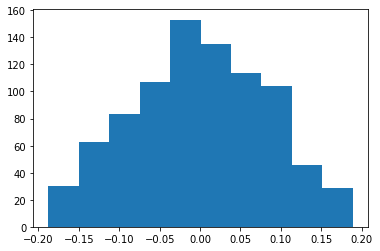

In [22]:
x = layers.Conv2D(32, kernel_size=3, strides=(2, 2), kernel_initializer=CONV_KERNEL_INIT)
get_layer_weights(x)

In [23]:
def efficientnet(input_tensor=None, input_shape=None, phi=0, model_name="efficientnet_base", image_data_format="channels_last", drop_connect_rate=0.2):
    bn_axis = 3 if image_data_format=="channels_last" else 1
    # EfficientNet B0 Values (alpha = depth (num layers), beta = width (num filters), gamma = resolution)
    alpha, beta, gamma = 1.2, 1.1, 1.15
    depth_coeff, width_coeff, res_coeff = alpha**phi, beta**phi, gamma**phi
    # Create Stem
    input_layer = Input(shape=input_shape) if input_tensor is None else input_tensor
    x = layers.Conv2D(round_num_filters(32, width_coeff, rounding_multiple=8), kernel_size=3, strides=(2, 2), padding="same", use_bias=False, kernel_initializer=CONV_KERNEL_INIT, name="stem_conv")(input_layer)
    x = layers.BatchNormalization(axis=bn_axis, name='stem_bn')(x)
    x = layers.Activation("swish", name="stem_swish")(x)
    # Build MBConv Blocks
#     I feel like total_network_blocks should include the actual number of repeats due to depth_coeff as well...
    total_network_blocks = sum(round_num_repeats(block.num_repeat, depth_coeff) for block in BASELINE_NETWORK_PARAMS)
    block_num = 0
    for idx, block_args in enumerate(BASELINE_NETWORK_PARAMS):
        input_filters = round_num_filters(block_args.input_filters, width_coeff, rounding_multiple=8)
        output_filters = round_num_filters(block_args.output_filters, width_coeff, rounding_multiple=8)
        num_repeat = round_num_repeats(block_args.num_repeat, depth_coeff)
        drop_rate = scaled_dropout(drop_connect_rate, block_num, total_network_blocks)
        x = new_mb_conv_block(x, input_filters, output_filters, "block{}_a_".format(idx+1), depthwise_kernel_size=block_args.depthwise_kernel_size, depthwise_strides=block_args.strides, se_ratio=block_args.se_ratio, drop_rate=drop_rate, expand_ratio=block_args.expand_ratio)
        block_num += 1
        # If repeated block
        if num_repeat > 1:
            # Note we already repeated the first block
            for bidx in range(1, num_repeat):
                drop_rate = scaled_dropout(drop_connect_rate, block_num, total_network_blocks)
                # Input filters needs to be changed so that it matches the first block's output filters
                x = new_mb_conv_block(x, output_filters, output_filters, "block{}_{}_".format(idx+1, string.ascii_lowercase[bidx]), depthwise_kernel_size=block_args.depthwise_kernel_size, depthwise_strides=[1, 1], se_ratio=block_args.se_ratio, drop_rate=drop_rate, expand_ratio=block_args.expand_ratio)
                block_num += 1
    # Build Top
    # Final conv layer in provided baseline network
    x = layers.Conv2D(round_num_filters(1280, width_coeff, rounding_multiple=8), 1, padding='same', use_bias=False, kernel_initializer=CONV_KERNEL_INIT, name='top_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='top_bn')(x)
    x = layers.Activation("swish")(x)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    
    # Return output
    return x

In [24]:
# mb_input = layers.Input((112, 112, 32))
ting = next(train_generator)
#     return EfficientNet(1.0, 1.0, 224, 0.2,
#                         model_name='efficientnet-b0',
#                         include_top=include_top, weights=weights,
#                         input_tensor=input_tensor, input_shape=input_shape,
#                         pooling=pooling, classes=classes,
#                         **kwargs)
ting[0].shape
model_input = layers.Input((150, 150, 3))
model_output = efficientnet(model_input)

32 16 [1, 1]
16 24 [2, 2]
24 24 [1, 1]
here 0.025
24 40 [2, 2]
40 40 [1, 1]
here 0.05
40 80 [2, 2]
80 80 [1, 1]
here 0.07500000000000001
80 80 [1, 1]
here 0.08750000000000001
80 112 [1, 1]
112 112 [1, 1]
here 0.1125
112 112 [1, 1]
here 0.125
112 192 [2, 2]
192 192 [1, 1]
here 0.15000000000000002
192 192 [1, 1]
here 0.1625
192 192 [1, 1]
here 0.17500000000000002
192 320 [1, 1]


excite[0][0]       
__________________________________________________________________________________________________
block5_b___project_bn (BatchNor (None, 10, 10, 112)  448         block5_b___project_conv[0][0]    
__________________________________________________________________________________________________
block5_b_drop (Dropout)         (None, 10, 10, 112)  0           block5_b___project_bn[0][0]      
__________________________________________________________________________________________________
block5_b___residual (Add)       (None, 10, 10, 112)  0           block5_b_drop[0][0]              
                                                                 block5_a___project_bn[0][0]      
__________________________________________________________________________________________________
block5_c___expand_conv (Conv2D) (None, 10, 10, 672)  75264       block5_b___residual[0][0]        
_________________________________________________________________________________________

In [25]:
# model.summary()

IMAGENET_WEIGHTS_PATH = (
    'https://github.com/Callidior/keras-applications/'
    'releases/download/efficientnet/')

IMAGENET_WEIGHTS_HASHES = {
    'efficientnet-b0': ('163292582f1c6eaca8e7dc7b51b01c61'
                        '5b0dbc0039699b4dcd0b975cc21533dc',
                        'c1421ad80a9fc67c2cc4000f666aa507'
                        '89ce39eedb4e06d531b0c593890ccff3'),
    'efficientnet-b1': ('d0a71ddf51ef7a0ca425bab32b7fa7f1'
                        '6043ee598ecee73fc674d9560c8f09b0',
                        '75de265d03ac52fa74f2f510455ba64f'
                        '9c7c5fd96dc923cd4bfefa3d680c4b68'),
    'efficientnet-b2': ('bb5451507a6418a574534aa76a91b106'
                        'f6b605f3b5dde0b21055694319853086',
                        '433b60584fafba1ea3de07443b74cfd3'
                        '2ce004a012020b07ef69e22ba8669333'),
    'efficientnet-b3': ('03f1fba367f070bd2545f081cfa7f3e7'
                        '6f5e1aa3b6f4db700f00552901e75ab9',
                        'c5d42eb6cfae8567b418ad3845cfd63a'
                        'a48b87f1bd5df8658a49375a9f3135c7'),
    'efficientnet-b4': ('98852de93f74d9833c8640474b2c698d'
                        'b45ec60690c75b3bacb1845e907bf94f',
                        '7942c1407ff1feb34113995864970cd4'
                        'd9d91ea64877e8d9c38b6c1e0767c411'),
    'efficientnet-b5': ('30172f1d45f9b8a41352d4219bf930ee'
                        '3339025fd26ab314a817ba8918fefc7d',
                        '9d197bc2bfe29165c10a2af8c2ebc675'
                        '07f5d70456f09e584c71b822941b1952'),
    'efficientnet-b6': ('f5270466747753485a082092ac9939ca'
                        'a546eb3f09edca6d6fff842cad938720',
                        '1d0923bb038f2f8060faaf0a0449db4b'
                        '96549a881747b7c7678724ac79f427ed'),
    'efficientnet-b7': ('876a41319980638fa597acbbf956a82d'
                        '10819531ff2dcb1a52277f10c7aefa1a',
                        '60b56ff3a8daccc8d96edfd40b204c11'
                        '3e51748da657afd58034d54d3cec2bac')
}

NS_WEIGHTS_PATH = 'https://github.com/qubvel/efficientnet/releases/download/v0.0.1/'
NS_WEIGHTS_HASHES = {
    'efficientnet-b0': ('5e376ca93bc6ba60f5245d13d44e4323', 'a5b48ae7547fc990c7e4f3951230290d'),
    'efficientnet-b1': ('79d29151fdaec95ac78e1ca97fc09634', '4d35baa41ca36f175506a33918f7e334'),
    'efficientnet-b2': ('8c643222ffb73a2bfdbdf90f2cde01af', 'e496e531f41242598288ff3a4b4199f9'),
    'efficientnet-b3': ('3b29e32602dad75d1f575d9ded00f930', '47da5b154de1372b557a65795d3e6135'),
    'efficientnet-b4': ('c000bfa03bf3c93557851b4e1fe18f51', '47c10902a4949eec589ab92fe1c35ed8'),
    'efficientnet-b5': ('8a920cd4ee793f53c251a1ecd3a5cee6', '4d53ef3544d4114e2d8080d6d777a74c'),
    'efficientnet-b6': ('cc69df409516ab57e30e51016326853e', '71f96d7e15d9f891f3729b4f4e701f77'),
    'efficientnet-b7': ('1ac825752cbc26901c8952e030ae4dd9', 'e112b00c464fe929b821edbb35d1af55')
}

In [26]:
# file_name = "{}_{}_notop.h5".format('efficientnet-b0', 'noisy-student')
# file_hash = NS_WEIGHTS_HASHES['efficientnet-b0'][1]
# weights_path = keras.utils.get_file(file_name, NS_WEIGHTS_PATH + file_name, cache_subdir='models', file_hash=file_hash)
model_name='efficientnet-b0'
file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5'
file_hash = IMAGENET_WEIGHTS_HASHES[model_name][1]
weights_path = keras.utils.get_file(
            file_name,
            IMAGENET_WEIGHTS_PATH + file_name,
            cache_subdir='models',
            file_hash=file_hash,
        )

In [27]:
base_model = models.Model(model_input, model_output)
base_model.load_weights(weights_path)

In [28]:
ting = Dense(128, activation="relu")(base_model.output)
predictions = Dense(8, activation='softmax')(ting)
model = models.Model(base_model.input, predictions)
model.summary()

ject_conv[0][0]    
__________________________________________________________________________________________________
block5_b_drop (Dropout)         (None, 10, 10, 112)  0           block5_b___project_bn[0][0]      
__________________________________________________________________________________________________
block5_b___residual (Add)       (None, 10, 10, 112)  0           block5_b_drop[0][0]              
                                                                 block5_a___project_bn[0][0]      
__________________________________________________________________________________________________
block5_c___expand_conv (Conv2D) (None, 10, 10, 672)  75264       block5_b___residual[0][0]        
__________________________________________________________________________________________________
block5_c___expand_bn (BatchNorm (None, 10, 10, 672)  2688        block5_c___expand_conv[0][0]     
_________________________________________________________________________________________

In [29]:
# freeze_model_layers(model, trainable_start=len(base_model.layers))
# Probabilities produced by softmax will always sum to 1
default_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
slow_adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=default_adam,metrics=['accuracy'])

In [30]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = ModelCheckpoint('vgg_16_step_1.h5', monitor='val_loss', mode='min', save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.5, min_lr=0.0000001)
history = model.fit_generator(train_generator,steps_per_epoch=train_steps, epochs=60,
                              validation_data=validation_generator,validation_steps=validation_steps,
                              callbacks=[es, mc, learning_rate_reduction],
                              workers=6, max_queue_size=30)

Epoch 1/60
111/111 [==============================] - 23s 212ms/step - loss: 0.5485 - acc: 0.8108 - val_loss: 0.3383 - val_acc: 0.8900
Epoch 2/60
111/111 [==============================] - 14s 129ms/step - loss: 0.3406 - acc: 0.8871 - val_loss: 0.6804 - val_acc: 0.8164
Epoch 3/60
111/111 [==============================] - 14s 128ms/step - loss: 0.2741 - acc: 0.9085 - val_loss: 0.2810 - val_acc: 0.9229
Epoch 4/60
111/111 [==============================] - 14s 129ms/step - loss: 0.2424 - acc: 0.9169 - val_loss: 0.1707 - val_acc: 0.9388
Epoch 5/60
111/111 [==============================] - 14s 128ms/step - loss: 0.2035 - acc: 0.9276 - val_loss: 0.1835 - val_acc: 0.9388
Epoch 6/60
 62/111 [===============>..............] - ETA: 6s - loss: 0.2312 - acc: 0.9218

KeyboardInterrupt: 